# Previsão de vazão de rios

Utilizam-se os dados de furnas e de camargos.

Importam-se as seguintes bibliotecas externas:

 - pandas
 - matplotlib
 - statsmodels
 - sklearn
 - seaborn
 - numpy
 - keras
 - theano
 - pmdarima >= 1.3.0
 
A aplicação jupyternotify é usada para notificar o fim da execução do código

In [1]:
%load_ext jupyternotify
%autonotify -a 10

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import pickle

import os
from glob import glob
os.environ['KERAS_BACKEND'] = 'theano'
#export THEANO_FLAGS=blas.ldflags="-L${MKLROOT}/lib/intel64 -lmkl_rt -lpthread -lm -ldl"
#os.environ['THEANO_FLAGS'] = blas.ldflags="-L/usr/lib64/atlas/ -lptf77blas -lptcblas -latlas"' #'blas.ldflags="-L/usr/lib64/ -lblas"'#'blas.ldflags="-L/usr/lib64/ -lf77blas -latlas -lgfortran"' #"-L/usr/local/lib/ -lblas"'

from keras.models import Sequential, load_model, Model
from keras import regularizers
from keras.layers import Concatenate, Permute, Dot, Input, LSTM, Multiply, RepeatVector, Dense, Activation, Lambda
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, GaussianNoise, GaussianDropout, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (15, 10)
if not os.path.exists('historicos_clima'):
    os.makedirs('historicos_clima')
if not os.path.exists('modelos_clima'):
    os.makedirs('modelos_clima')

Using Theano backend.


Definição de constantes:

In [3]:
janela = 12
adicional_reco = 60
teste = 120
fracao_valida = 0.2

Funções auxiliadoras para o cálculo de métricas, demonstração gráficas e montagem das matrizes

In [4]:
indices_teste_seco = [k for k in range(-teste,0) if k%-12 in [-8,-7,-6,-5,-4,-3]]
indices_teste_umido = [k for k in range(-teste,0) if k%-12 in [0,-11,-10,-9,-2,-1]]

def imprime_metricas(real, predito, fator_normalizacao, teste=False):
    print('RMSE = ', np.sqrt(np.mean(np.square(predito - real)))*fator_normalizacao, end=', ')
    print('MSE = ', metrics.mean_squared_error(real, predito)*fator_normalizacao**2 , end=', ')
    print('MAPE = ', 100*np.mean(np.abs(predito-real)/real), '%', end=', ')
    print('MAE = ', metrics.mean_absolute_error(real, predito)*fator_normalizacao , end=', ')
    print('R = ', metrics.r2_score(real, predito))
    if teste:
        ps = predito[indices_teste_seco]
        rs = real[indices_teste_seco]
        pu = predito[indices_teste_umido]
        ru = real[indices_teste_umido]
        print('MAPE seco = ', 100*np.mean(np.abs(ps-rs)/rs), '%')
        print('MAPE umido = ', 100*np.mean(np.abs(pu-ru)/ru), '%')

def mostra_treinamento(historico, init=16):
    plt.plot(historico['loss'][init:])
    plt.plot(historico['val_loss'][init:])
    plt.ylabel('Erro Relativo Médio')
    plt.xlabel('Iterações')
    plt.legend(['Treinamento', 'Validação'], loc='upper right')
    plt.show()

def mostra_performance(modelo, entrada, saida, fatores_normalizacao, teste=False):
    predito = modelo.predict(entrada)
    nomes = ['Furnas', 'Camargos']
    for i in range(len(fatores_normalizacao)):
        print(nomes[i])
        plt.plot(saida[:, i], '-o')
        plt.plot(predito[:, i], '-o')
        plt.legend(['Real', 'Predito'], loc='upper right')
        if teste:
            plt.xticks([0]+[(k+1)*12-1 for k in range(10)], ['jan/03']+['dez/%02d'%(k+3) for k in range(10)])
        else:
            plt.xticks(np.arange(0, len(saida)+1, step=12))
        plt.show()
        imprime_metricas(saida[:, i], predito[:, i], fatores_normalizacao[i], teste)

def salva_historico(historico, nome_arquivo):
    arquivo = open(nome_arquivo, 'wb')
    pickle.dump(historico, arquivo)
    arquivo.close()

def carrega_historico(nome_arquivo):
    try:
        arquivo = open(nome_arquivo, 'rb')
        historico = pickle.load(arquivo)
        arquivo.close()
    except:
        return False
    return historico

def separa_series_clima(serie1, serie2, clima, janela, inicio_y, tam):
    x_separado = np.zeros((tam, 2*janela+clima.shape[1]))
    for i in range(tam):
        x_separado[i, 0:janela] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, janela:2*janela] = serie2[i+inicio_y-janela:i+inicio_y]
    x_separado[:, 2*janela:] = clima[inicio_y-1:inicio_y+tam-1,:]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def gera_meses(inicio_y, tam):
    meses = np.zeros((tam, 12))
    for i in range(tam):
        meses[i, (i+inicio_y)%12] = 1
    return meses

def separa_series_reco_clima(serie1, serie2, clima, janela, inicio_y, tam):
    x_separado = np.zeros((tam, janela, 2 + clima.shape[1]))
    for i in range(tam):
        x_separado[i, :, 0] = serie1[i+inicio_y-janela:i+inicio_y]
        x_separado[i, :, 1] = serie2[i+inicio_y-janela:i+inicio_y]
        x_separado[i, :, 2:] = clima[i+inicio_y-janela:i+inicio_y, :]
    y_separado = np.zeros((tam, 2))
    y_separado[:, 0] = serie1[inicio_y:inicio_y+tam]
    y_separado[:, 1] = serie2[inicio_y:inicio_y+tam]
    return x_separado, y_separado

def gera_meses_reco(janela, inicio_y, tam):
    meses = np.zeros((tam, janela, 12))
    for i in range(tam):
        for j in range(janela):
            meses[i, j, (i+j+inicio_y)%12] = 1
    return meses

Carregamento incial dos dados

In [5]:
pasta_dados = 'dados/clima'
#atributos = ['VelocidadeVentoMedia','VelocidadeVentoMaximaMedia','EvaporacaoPiche','NebulosidadeMedia','PrecipitacaoTotal','TempMaximaMedia','TempCompensadaMedia', 'TempMinimaMedia', 'UmidadeRelativaMedia']
#atributos = ['EvaporacaoPiche','NebulosidadeMedia','PrecipitacaoTotal','TempCompensadaMedia', 'UmidadeRelativaMedia']
atributos = ['EvaporacaoPiche', 'PrecipitacaoTotal']

def carrega_clima(pasta_dados):
    quant_meses = 624
    dados = np.zeros((quant_meses, len(atributos)*len(glob('dados/clima/*.csv'))))
    for i, arquivo in enumerate(glob(pasta_dados+'/*.csv')):
        print(arquivo, end=', ')
        tabela = pd.read_csv('./dados/clima/sao-lourenco.csv', parse_dates=['Data'], index_col='Data', sep=';')
        valores = tabela.loc[:'2012',atributos].resample('M').mean().interpolate(limit_direction='both').values
        assert(valores.shape[0] == quant_meses)
        dados[:,i*len(atributos):(i+1)*len(atributos)] = valores[:,:]
    return dados

dados_clima = carrega_clima(pasta_dados)

dados/clima/sao-carlos.csv, dados/clima/resende.csv, dados/clima/sao-lourenco.csv, dados/clima/lavras.csv, dados/clima/belo-horizonte.csv, dados/clima/campos-do-jordao.csv, dados/clima/machado.csv, dados/clima/caldas.csv, 

In [6]:
furnas = np.array([float(a) for a in open('dados/furnas.csv', 'r').read().split('\n') if a])
camargos = np.array([float(a) for a in open('dados/camargos.csv', 'r').read().split('\n') if a])
assert(len(furnas) == len(camargos))
assert(dados_clima.shape[0] <= len(furnas - teste - janela))
offset = len(furnas) - dados_clima.shape[0] + 1
valida = int((dados_clima.shape[0] - teste - 1) * fracao_valida)
treino = dados_clima.shape[0] - teste - valida - 1
fatores_normalizacao = [furnas[:treino].max(), camargos[:treino].max()]
furnas /= fatores_normalizacao[0]
camargos /= fatores_normalizacao[1]
dados_clima_pad = np.zeros((len(furnas), dados_clima.shape[1]))
dados_clima_pad[len(furnas) - dados_clima.shape[0]:, :] = dados_clima[:,:]
dados_clima_pad /= dados_clima.max(axis=0)

x_treina, y_treina = separa_series_clima(furnas, camargos, dados_clima_pad, janela, offset, treino)
m_treina = gera_meses(offset, treino)
x_valida, y_valida = separa_series_clima(furnas, camargos, dados_clima_pad, janela, offset+treino, valida)
m_valida = gera_meses(offset+treino, valida)
x_teste, y_teste = separa_series_clima(furnas, camargos, dados_clima_pad, janela, offset+treino+valida, teste)
m_teste = gera_meses(offset+treino+valida, teste)

assert(x_treina[31, janela-1] == y_treina[30, 0])
print('Treino, ', treino)
print('Validação, ', valida)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela)

Treino,  403
Validação,  100
Teste,  120
Total,  972


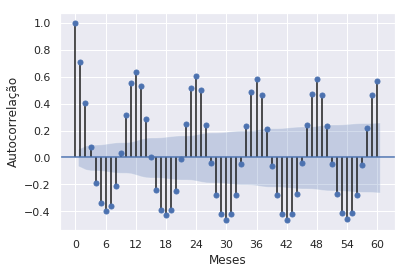

In [7]:
plot_acf(furnas, lags=60)
plt.xticks(np.arange(0, 61, step=6))
plt.title('')
plt.ylabel('Autocorrelação')
plt.xlabel('Meses')
plt.show()
plt.rcParams["figure.figsize"] = (14, 8)

# Um único neurônio (regressão linear)

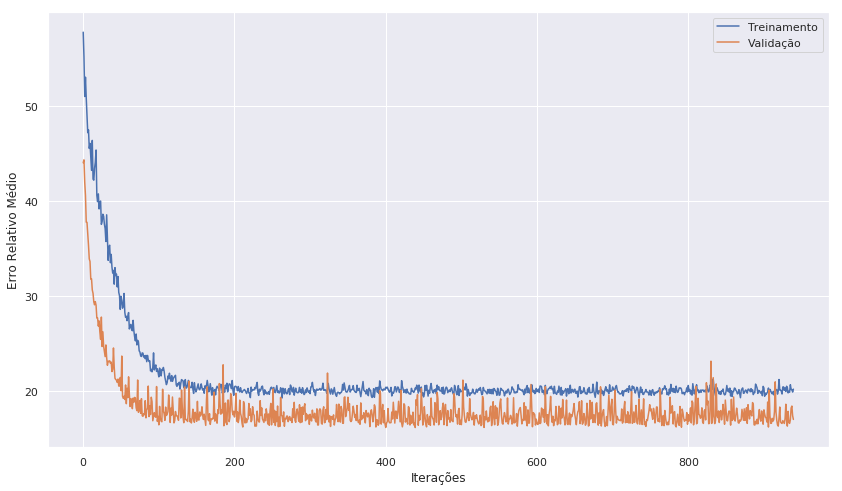

Furnas


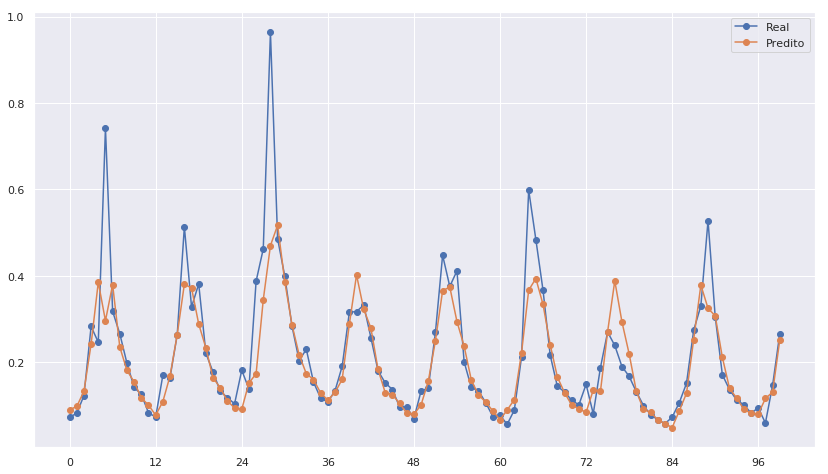

RMSE =  330.47175664073814, MSE =  109211.58193721525, MAPE =  17.497429531909514 %, MAE =  164.07572989590466, R =  0.6701118737731457
Camargos


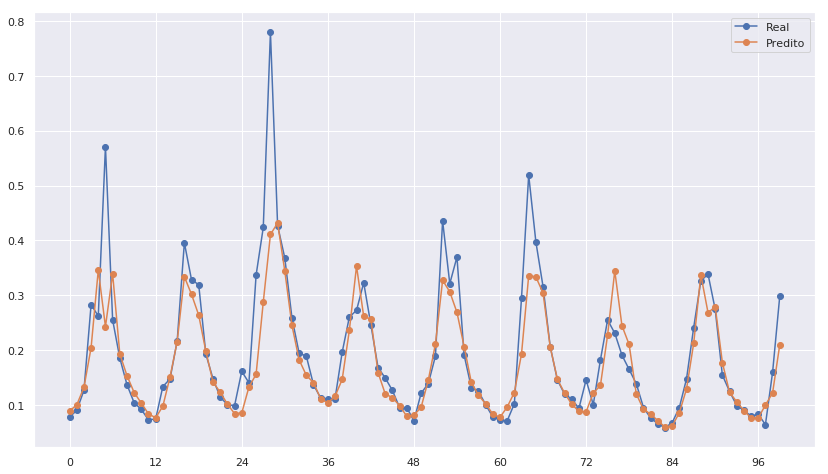

RMSE =  39.246394457670874, MSE =  1540.2794779270994, MAPE =  14.847533324721567 %, MAE =  20.578130872249602, R =  0.7028112910047017


In [8]:
def modelo_uno(janela, quant_rios, dim_adicional, ruido=0.05):
    entrada = Input(shape=(janela * quant_rios + dim_adicional,))
    mes = Input(shape=(12,), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    estimativa = Dense(quant_rios, activation='tanh')(entrada_aumentada)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_clima/melhor_uno.h5'):
    uno = modelo_uno(janela, 2, dados_clima.shape[1])
    uno.compile(optimizer='adam', loss='mape')
    parar_uno = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500, min_delta=0)
    salvar_uno = ModelCheckpoint('modelos_clima/melhor_uno.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_uno = uno.fit([x_treina, m_treina], y_treina, epochs=10000, validation_data=([x_valida, m_valida], y_valida), verbose=0, callbacks=[parar_uno, salvar_uno])
    salva_historico(historico_uno.history, 'historicos_clima/uno')
    
mostra_treinamento(carrega_historico('historicos_clima/uno'))
uno = load_model('modelos_clima/melhor_uno.h5')
mostra_performance(uno, [x_valida, m_valida], y_valida, fatores_normalizacao)

# Multilayer perceptron

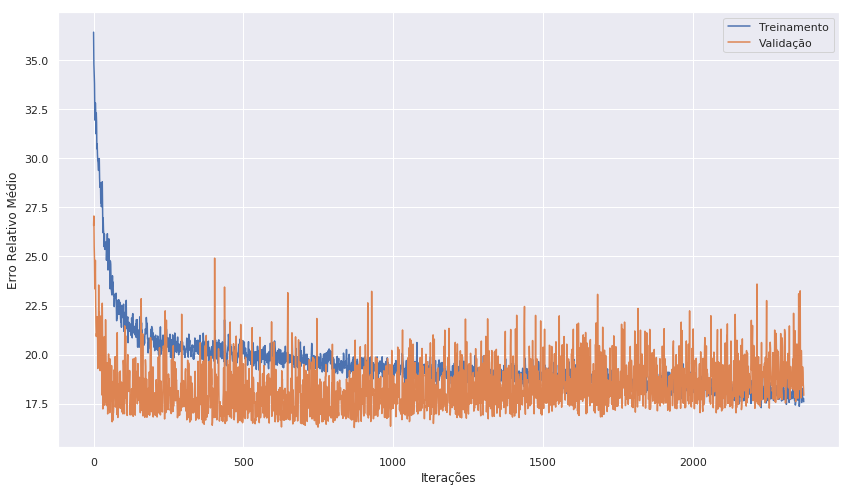

Furnas


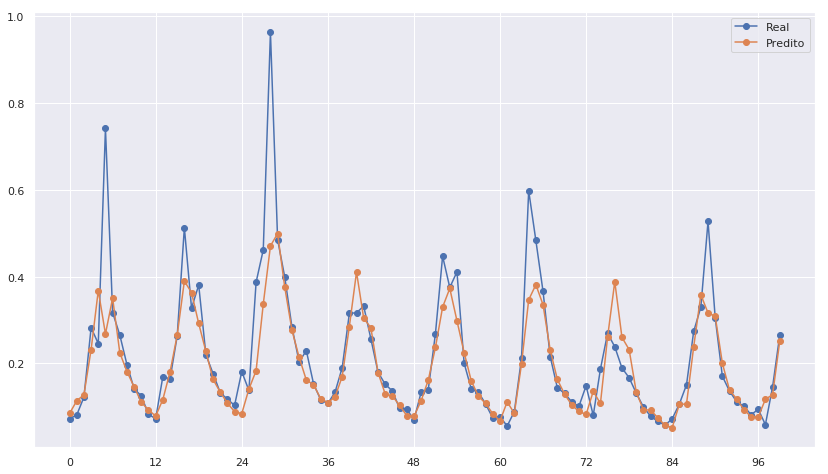

RMSE =  338.3107022016342, MSE =  114454.13122416282, MAPE =  17.78857720871464 %, MAE =  166.55777624875302, R =  0.6542760555362365
Camargos


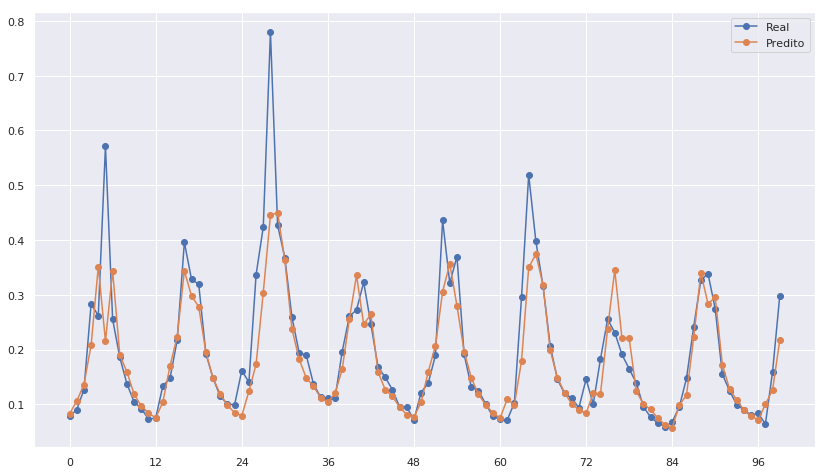

RMSE =  38.388232239838686, MSE =  1473.6563744997902, MAPE =  14.770964971067816 %, MAE =  20.07533099174499, R =  0.7156658634252008


In [9]:
def modelo_mlp(janela, quant_rios, dim_adicional, ruido=0.05):
    entrada = Input(shape=(janela*quant_rios + dim_adicional,))
    mes = Input(shape=(12,), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(12, activation='tanh')(entrada_aumentada)
    X = GaussianDropout(0.003)(X)
    X = Dense(6, activation='tanh')(X)
    X = GaussianDropout(0.001)(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_clima/melhor_mlp.h5'):
    mlp = modelo_mlp(janela, 2, dados_clima.shape[1])
    mlp.compile(optimizer='adam', loss='mape')
    parar_mlp = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1500, min_delta=0)
    salvar_mlp = ModelCheckpoint('modelos_clima/melhor_mlp.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_mlp = mlp.fit([x_treina, m_treina], y_treina, epochs=10000, validation_data=([x_valida, m_valida], y_valida), verbose=0, callbacks=[parar_mlp, salvar_mlp])
    salva_historico(historico_mlp.history, 'historicos_clima/mlp')

mostra_treinamento(carrega_historico('historicos_clima/mlp'))
mlp = load_model('modelos_clima/melhor_mlp.h5')
mostra_performance(mlp, [x_valida, m_valida], y_valida, fatores_normalizacao)

## Divisão do conjuntos de dados para redes recorrentes

Para o treinamento de redes recorrentes no Keras é necessário escrever um tensor de ordem 3

In [10]:
janela_reco = janela + adicional_reco
offset_reco = len(furnas) - dados_clima.shape[0] + janela_reco
valida_reco = int((dados_clima.shape[0] - teste - janela_reco) * fracao_valida)
treino_reco = dados_clima.shape[0] - teste - valida_reco - janela_reco

x_treina_reco, y_treina_reco = separa_series_reco_clima(furnas, camargos, dados_clima_pad, janela_reco, offset_reco, treino_reco)
m_treina_reco = gera_meses_reco(janela_reco, offset_reco, treino_reco)
x_valida_reco, y_valida_reco = separa_series_reco_clima(furnas, camargos, dados_clima_pad, janela_reco, offset_reco+treino_reco, valida_reco)
m_valida_reco = gera_meses_reco(janela_reco, offset_reco+treino_reco, valida_reco)
x_teste_reco, y_teste_reco = separa_series_reco_clima(furnas, camargos, dados_clima_pad, janela_reco, offset_reco+treino_reco+valida_reco, teste)
m_teste_reco = gera_meses_reco(janela_reco, offset_reco+treino_reco+valida_reco, teste)

assert(x_treina_reco[31, -1, 0] == y_treina_reco[30, 0])
print('Treino, ', treino_reco)
print('Validação, ', valida_reco)
print('Teste, ', teste)
print('Total, ', len(furnas) - janela_reco)

Treino,  346
Validação,  86
Teste,  120
Total,  912


## Rede Recorrente Simples

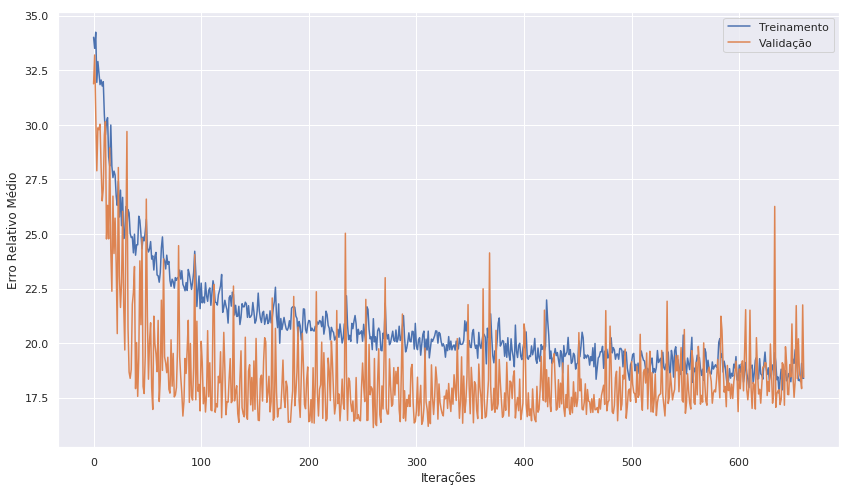

/usr/lib64/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Furnas


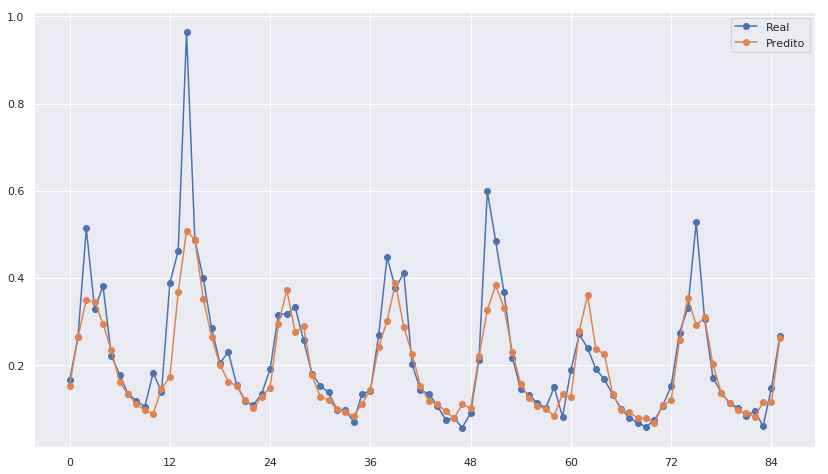

RMSE =  300.30097884894803, MSE =  90180.67789763631, MAPE =  16.633073882191294 %, MAE =  152.43587836969732, R =  0.7180740150165389
Camargos


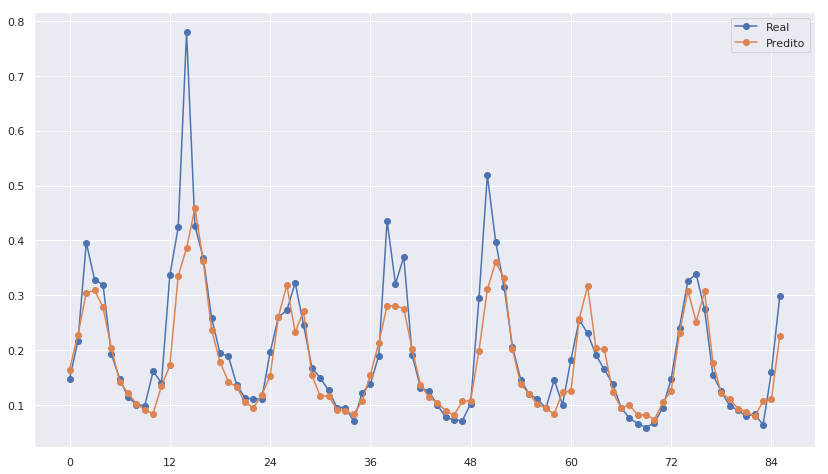

RMSE =  37.029101122984414, MSE =  1371.1543299762054, MAPE =  15.305733606989888 %, MAE =  19.80890712072683, R =  0.7308308532583372


<IPython.core.display.Javascript object>

In [11]:
def modelo_reco(janela, quant_rios, dim_adicional, ruido=0.05):
    entrada = Input(shape=(janela, quant_rios + dim_adicional))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(12, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(entrada_aumentada)
    X = GaussianDropout(0.004)(X)
    X = SimpleRNN(12)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='tanh')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_clima/melhor_reco.h5'):
    reco = modelo_reco(janela_reco, 2, dados_clima.shape[1])
    reco.compile(optimizer='adam', loss='mape')
    parar_reco = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400, min_delta=0)
    salvar_reco = ModelCheckpoint('modelos_clima/melhor_reco.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_reco = reco.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=10000, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_reco, salvar_reco])
    salva_historico(historico_reco.history, 'historicos_clima/reco')

mostra_treinamento(carrega_historico('historicos_clima/reco'))
reco = load_model('modelos_clima/melhor_reco.h5')
mostra_performance(reco, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

# LSTM

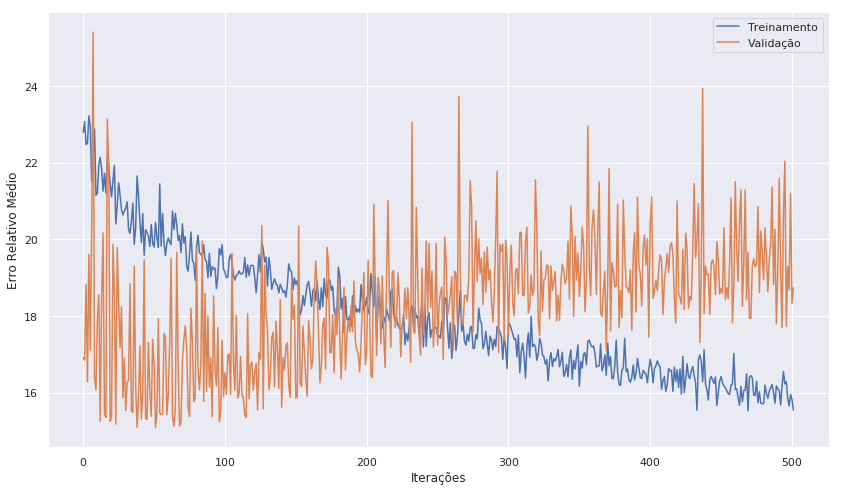

Furnas


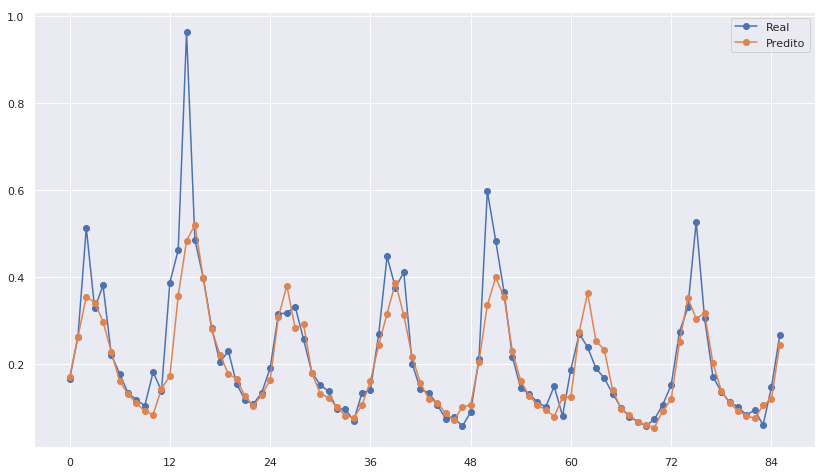

RMSE =  299.4753421973156, MSE =  89685.4805841993, MAPE =  16.022575778815416 %, MAE =  148.96612197056757, R =  0.7196221181535586
Camargos


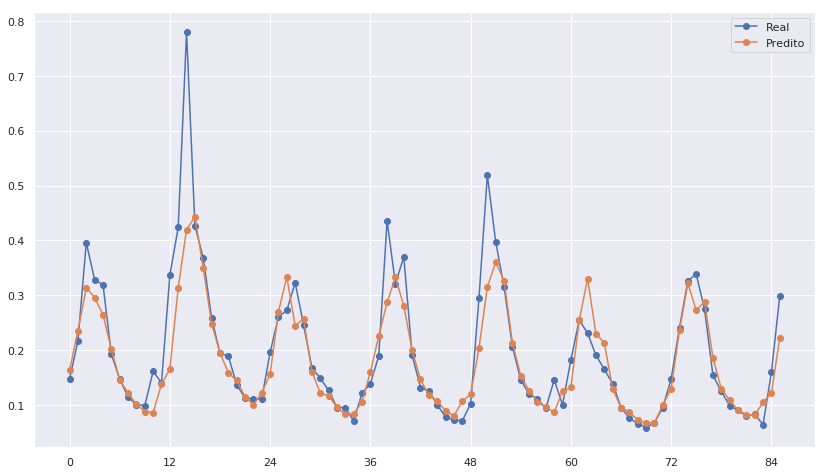

RMSE =  35.387293524838036, MSE =  1252.260543013044, MAPE =  14.155875695607701 %, MAE =  18.80570595763451, R =  0.7541707053013341


<IPython.core.display.Javascript object>

In [12]:
def modelo_lstm(janela, quant_rios, dim_adicional, ruido=0.03):
    entrada = Input(shape=(janela, quant_rios + dim_adicional))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(18, activation='tanh')(entrada_aumentada)
    X = LSTM(10)(X)
    X = GaussianDropout(0.004)(X)
    X = Dense(4, activation='tanh')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_clima/melhor_lstm.h5'):
    lstm = modelo_lstm(janela_reco, 2, dados_clima.shape[1])
    lstm.compile(optimizer='adam', loss='mape')
    parar_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=450, min_delta=0, restore_best_weights=True)
    salvar_lstm = ModelCheckpoint('modelos_clima/melhor_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)
    historico_lstm = lstm.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=7500, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_lstm, salvar_lstm])

    salva_historico(historico_lstm.history, 'historicos_clima/lstm')

mostra_treinamento(carrega_historico('historicos_clima/lstm'))
lstm = load_model('modelos_clima/melhor_lstm.h5')
mostra_performance(lstm, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

## GRU

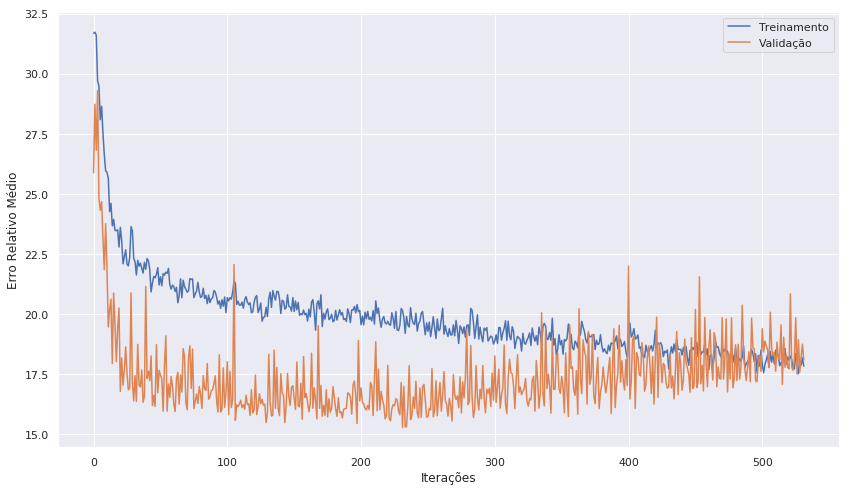

Furnas


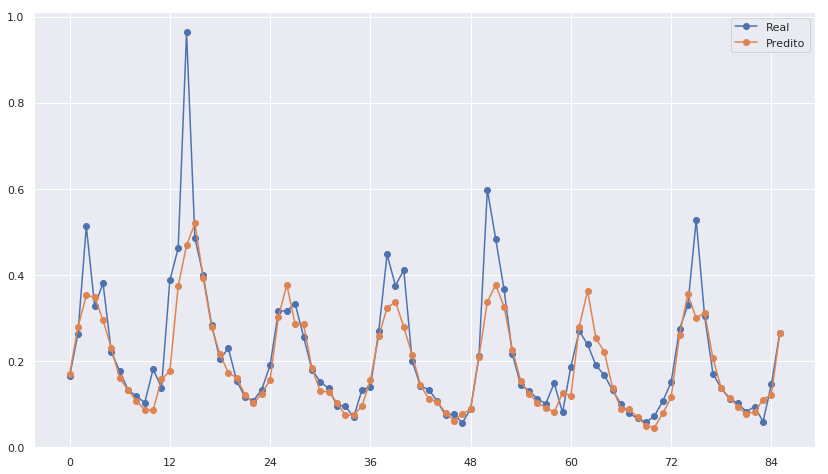

RMSE =  305.5049553532551, MSE =  93333.2777453944, MAPE =  16.42617173760358 %, MAE =  153.4963771211373, R =  0.7082182472616461
Camargos


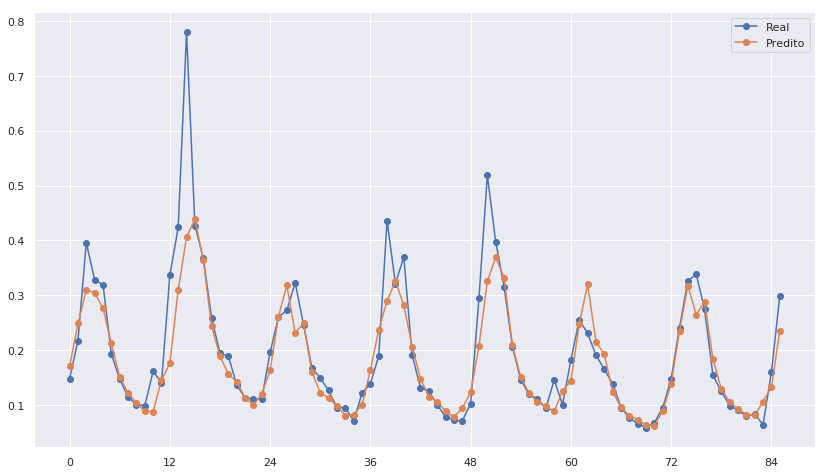

RMSE =  35.08358224113442, MSE =  1230.8577428704427, MAPE =  13.532530008984939 %, MAE =  18.128918852916986, R =  0.7583722552846728


In [13]:
def modelo_gru(janela, quant_rios, dim_adicional, ruido=0.03):
    entrada = Input(shape=(janela, quant_rios + dim_adicional))
    mes = Input(shape=(janela, 12), name='mes')
    
    entrada_ruidosa = GaussianDropout(ruido)(entrada)
    entrada_aumentada = Concatenate(axis=-1)([entrada_ruidosa, mes])
    X = Dense(12, activation='tanh', kernel_regularizer=regularizers.l2(0.02))(entrada_aumentada)
    X = GaussianDropout(0.004)(X)
    X = GRU(9)(X)
    X = GaussianDropout(0.002)(X)
    X = Dense(6, activation='tanh')(X)
    estimativa = Dense(quant_rios)(X)
    
    modelo = Model(inputs=[entrada, mes], outputs=estimativa)
    return modelo

if not os.path.isfile('modelos_clima/melhor_gru.h5'):
    gru = modelo_gru(janela_reco, 2, dados_clima.shape[1])
    gru.compile(optimizer='adam', loss='mape')
    parar_gru = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, min_delta=0)
    salvar_gru = ModelCheckpoint('modelos_clima/melhor_gru.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    historico_gru = gru.fit([x_treina_reco, m_treina_reco], y_treina_reco, epochs=2000, validation_data=([x_valida_reco, m_valida_reco], y_valida_reco), verbose=0, callbacks=[parar_gru, salvar_gru])
    salva_historico(historico_gru.history, 'historicos_clima/gru')

mostra_treinamento(carrega_historico('historicos_clima/gru'))
gru = load_model('modelos_clima/melhor_gru.h5')
mostra_performance(gru, [x_valida_reco, m_valida_reco], y_valida_reco, fatores_normalizacao)

## Teste dos modelos

Único Neurônio
Furnas


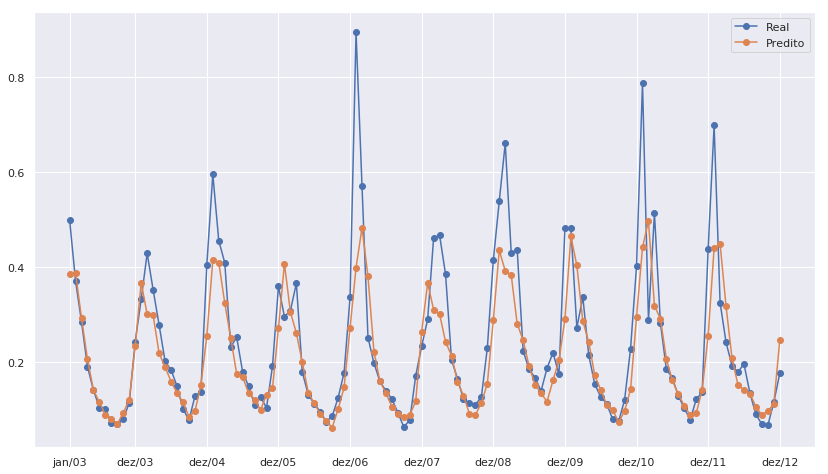

RMSE =  353.06064930703565, MSE =  124651.82208910563, MAPE =  18.46257165818912 %, MAE =  208.80998714504145, R =  0.6669308707382153
MAPE seco =  12.882145377593881 %
MAPE umido =  24.042997938784357 %
Camargos


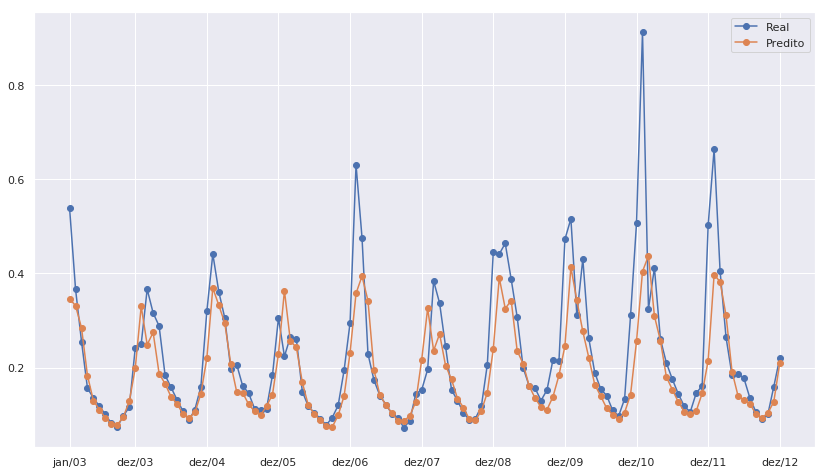

RMSE =  52.2394702126543, MSE =  2728.9622480987955, MAPE =  17.151009630584742 %, MAE =  29.46277486483256, R =  0.6048171036241372
MAPE seco =  9.966668976937852 %
MAPE umido =  24.335350284231623 %



MLP
Furnas


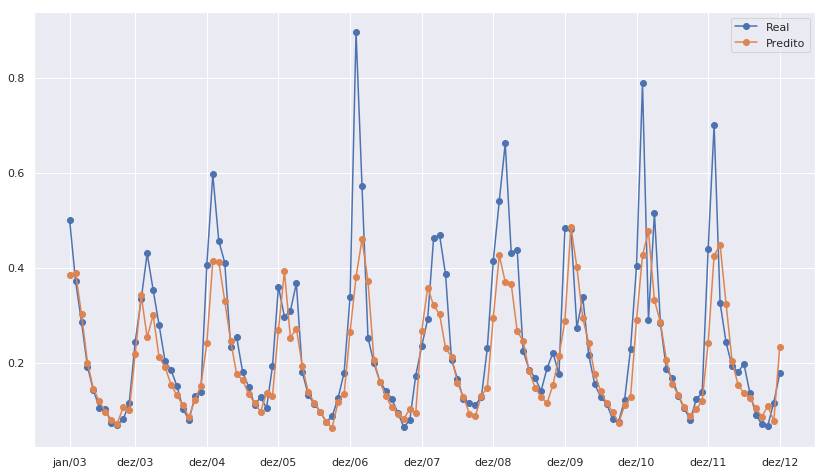

RMSE =  367.61778039233, MSE =  135142.8324605834, MAPE =  19.319510672226066 %, MAE =  217.83156776614487, R =  0.6388989364195444
MAPE seco =  12.921984542786008 %
MAPE umido =  25.717036801666115 %
Camargos


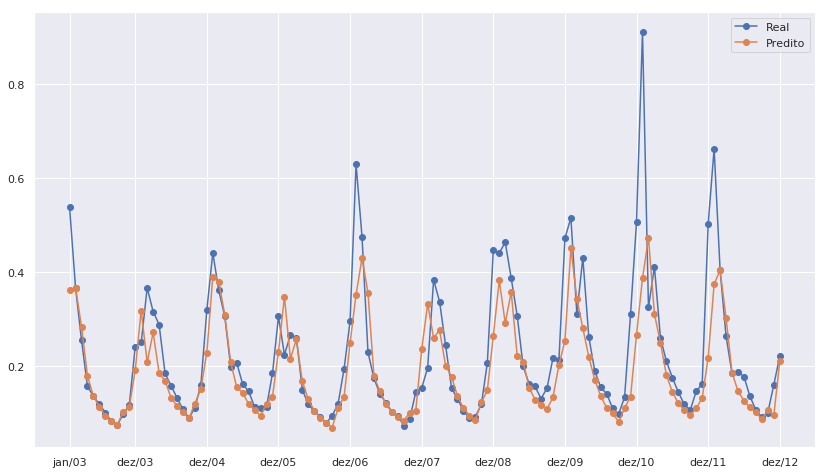

RMSE =  53.015221118064694, MSE =  2810.613670197293, MAPE =  17.70790066538728 %, MAE =  29.61657418807348, R =  0.5929931051424535
MAPE seco =  10.87386023911455 %
MAPE umido =  24.54194109166001 %



Recorrente Simples
Furnas


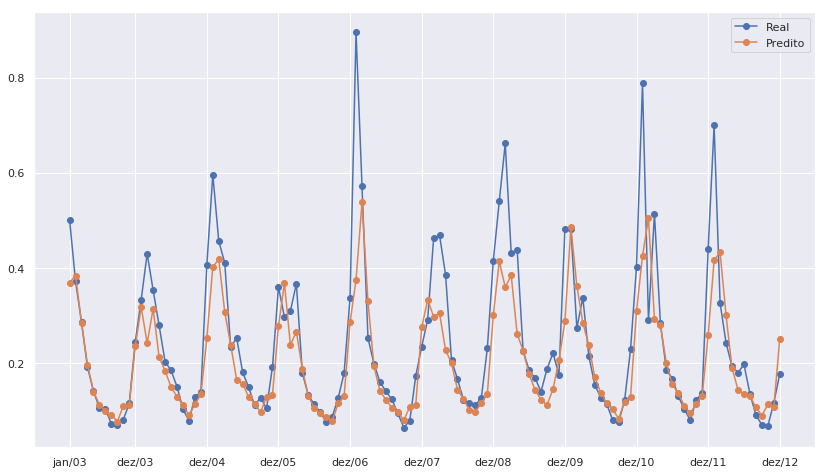

RMSE =  370.23643761154773, MSE =  137075.01973528948, MAPE =  18.971531368675397 %, MAE =  212.86751418896023, R =  0.6337361403819781
MAPE seco =  14.341371036996325 %
MAPE umido =  23.60169170035447 %
Camargos


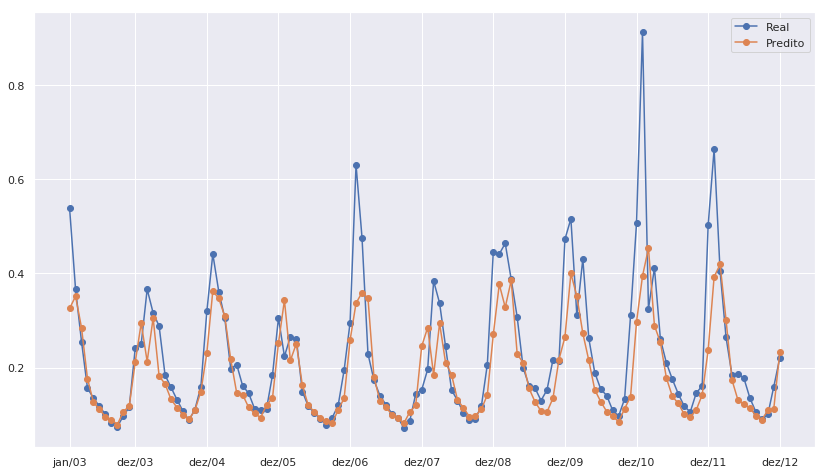

RMSE =  52.681391032984855, MSE =  2775.328961170257, MAPE =  17.835095362641518 %, MAE =  29.822426907221477, R =  0.5981027080769749
MAPE seco =  12.11019918868055 %
MAPE umido =  23.55999153660248 %



LSTM
Furnas


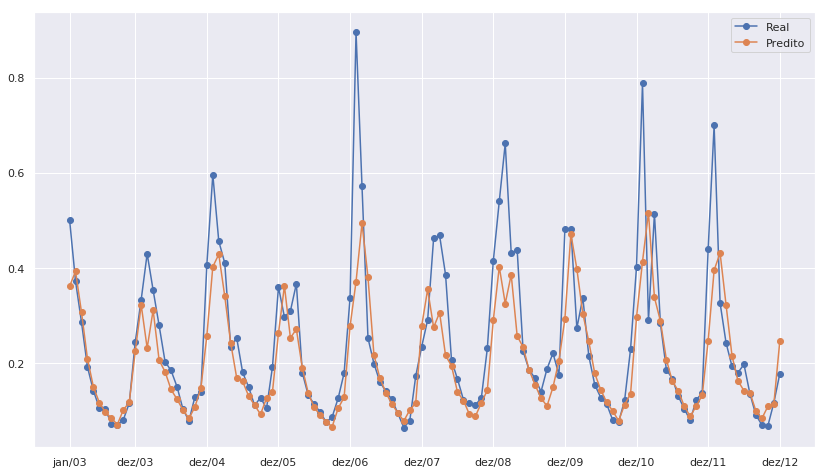

RMSE =  382.2061496082827, MSE =  146081.540798389, MAPE =  19.116872101832293 %, MAE =  220.7380200674137, R =  0.6096707550720055
MAPE seco =  13.062245975003913 %
MAPE umido =  25.17149822866067 %
Camargos


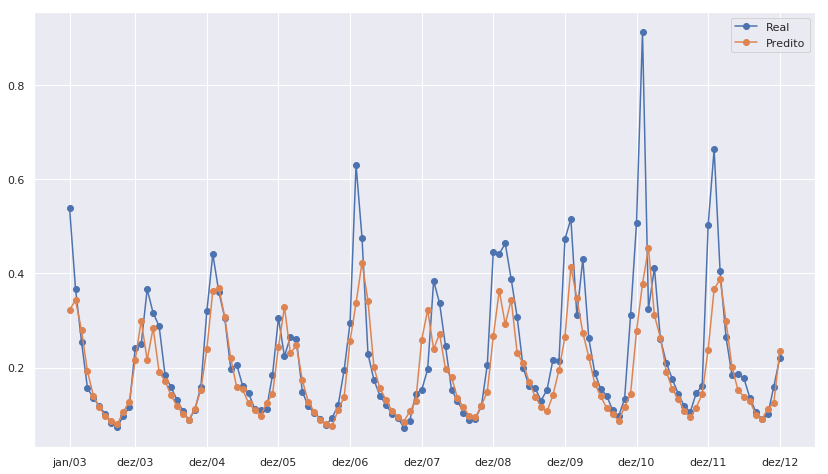

RMSE =  52.930347374157286, MSE =  2801.621673148959, MAPE =  17.040402897056776 %, MAE =  29.16219784021378, R =  0.5942952424073569
MAPE seco =  9.845587334773489 %
MAPE umido =  24.235218459340057 %



GRU
Furnas


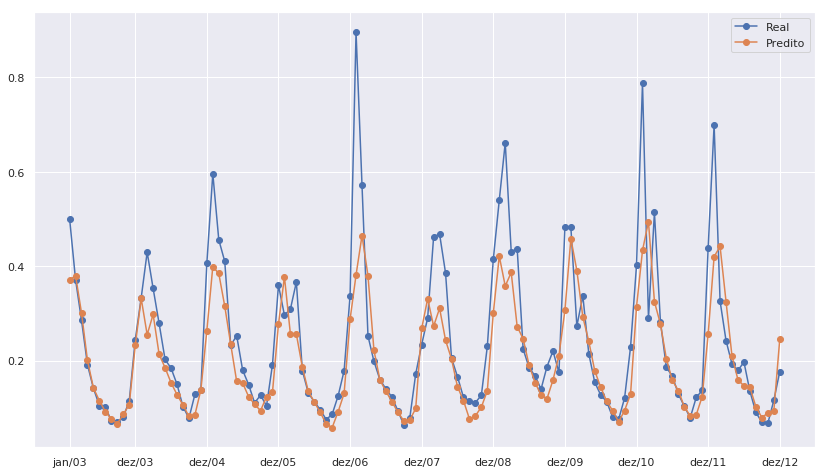

RMSE =  367.6872994532515, MSE =  135193.95017922504, MAPE =  18.939701356544226 %, MAE =  217.0544330745625, R =  0.6387623500965169
MAPE seco =  12.964354347819976 %
MAPE umido =  24.915048365268483 %
Camargos


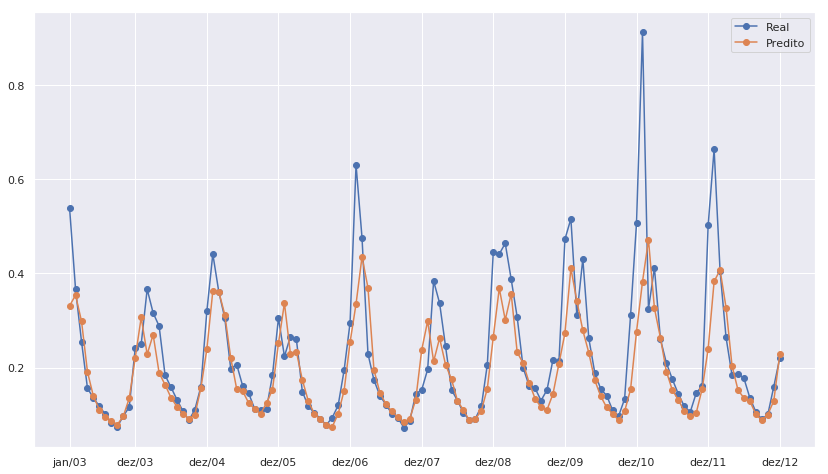

RMSE =  52.3242277814313, MSE =  2737.8248129231065, MAPE =  16.369979901474956 %, MAE =  28.490095619360606, R =  0.6035337095284403
MAPE seco =  9.234960832389351 %
MAPE umido =  23.504998970560564 %


In [14]:
executar_testes = True

if executar_testes:
    print('Único Neurônio')
    mostra_performance(uno, [x_teste, m_teste], y_teste, fatores_normalizacao, True)
    print('\n\n\nMLP')
    mostra_performance(mlp, [x_teste, m_teste], y_teste, fatores_normalizacao, True)
    print('\n\n\nRecorrente Simples')
    mostra_performance(reco, [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao, True)
    print('\n\n\nLSTM')
    mostra_performance(lstm, [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao, True)
    print('\n\n\nGRU')
    mostra_performance(gru , [x_teste_reco, m_teste_reco], y_teste_reco, fatores_normalizacao, True)

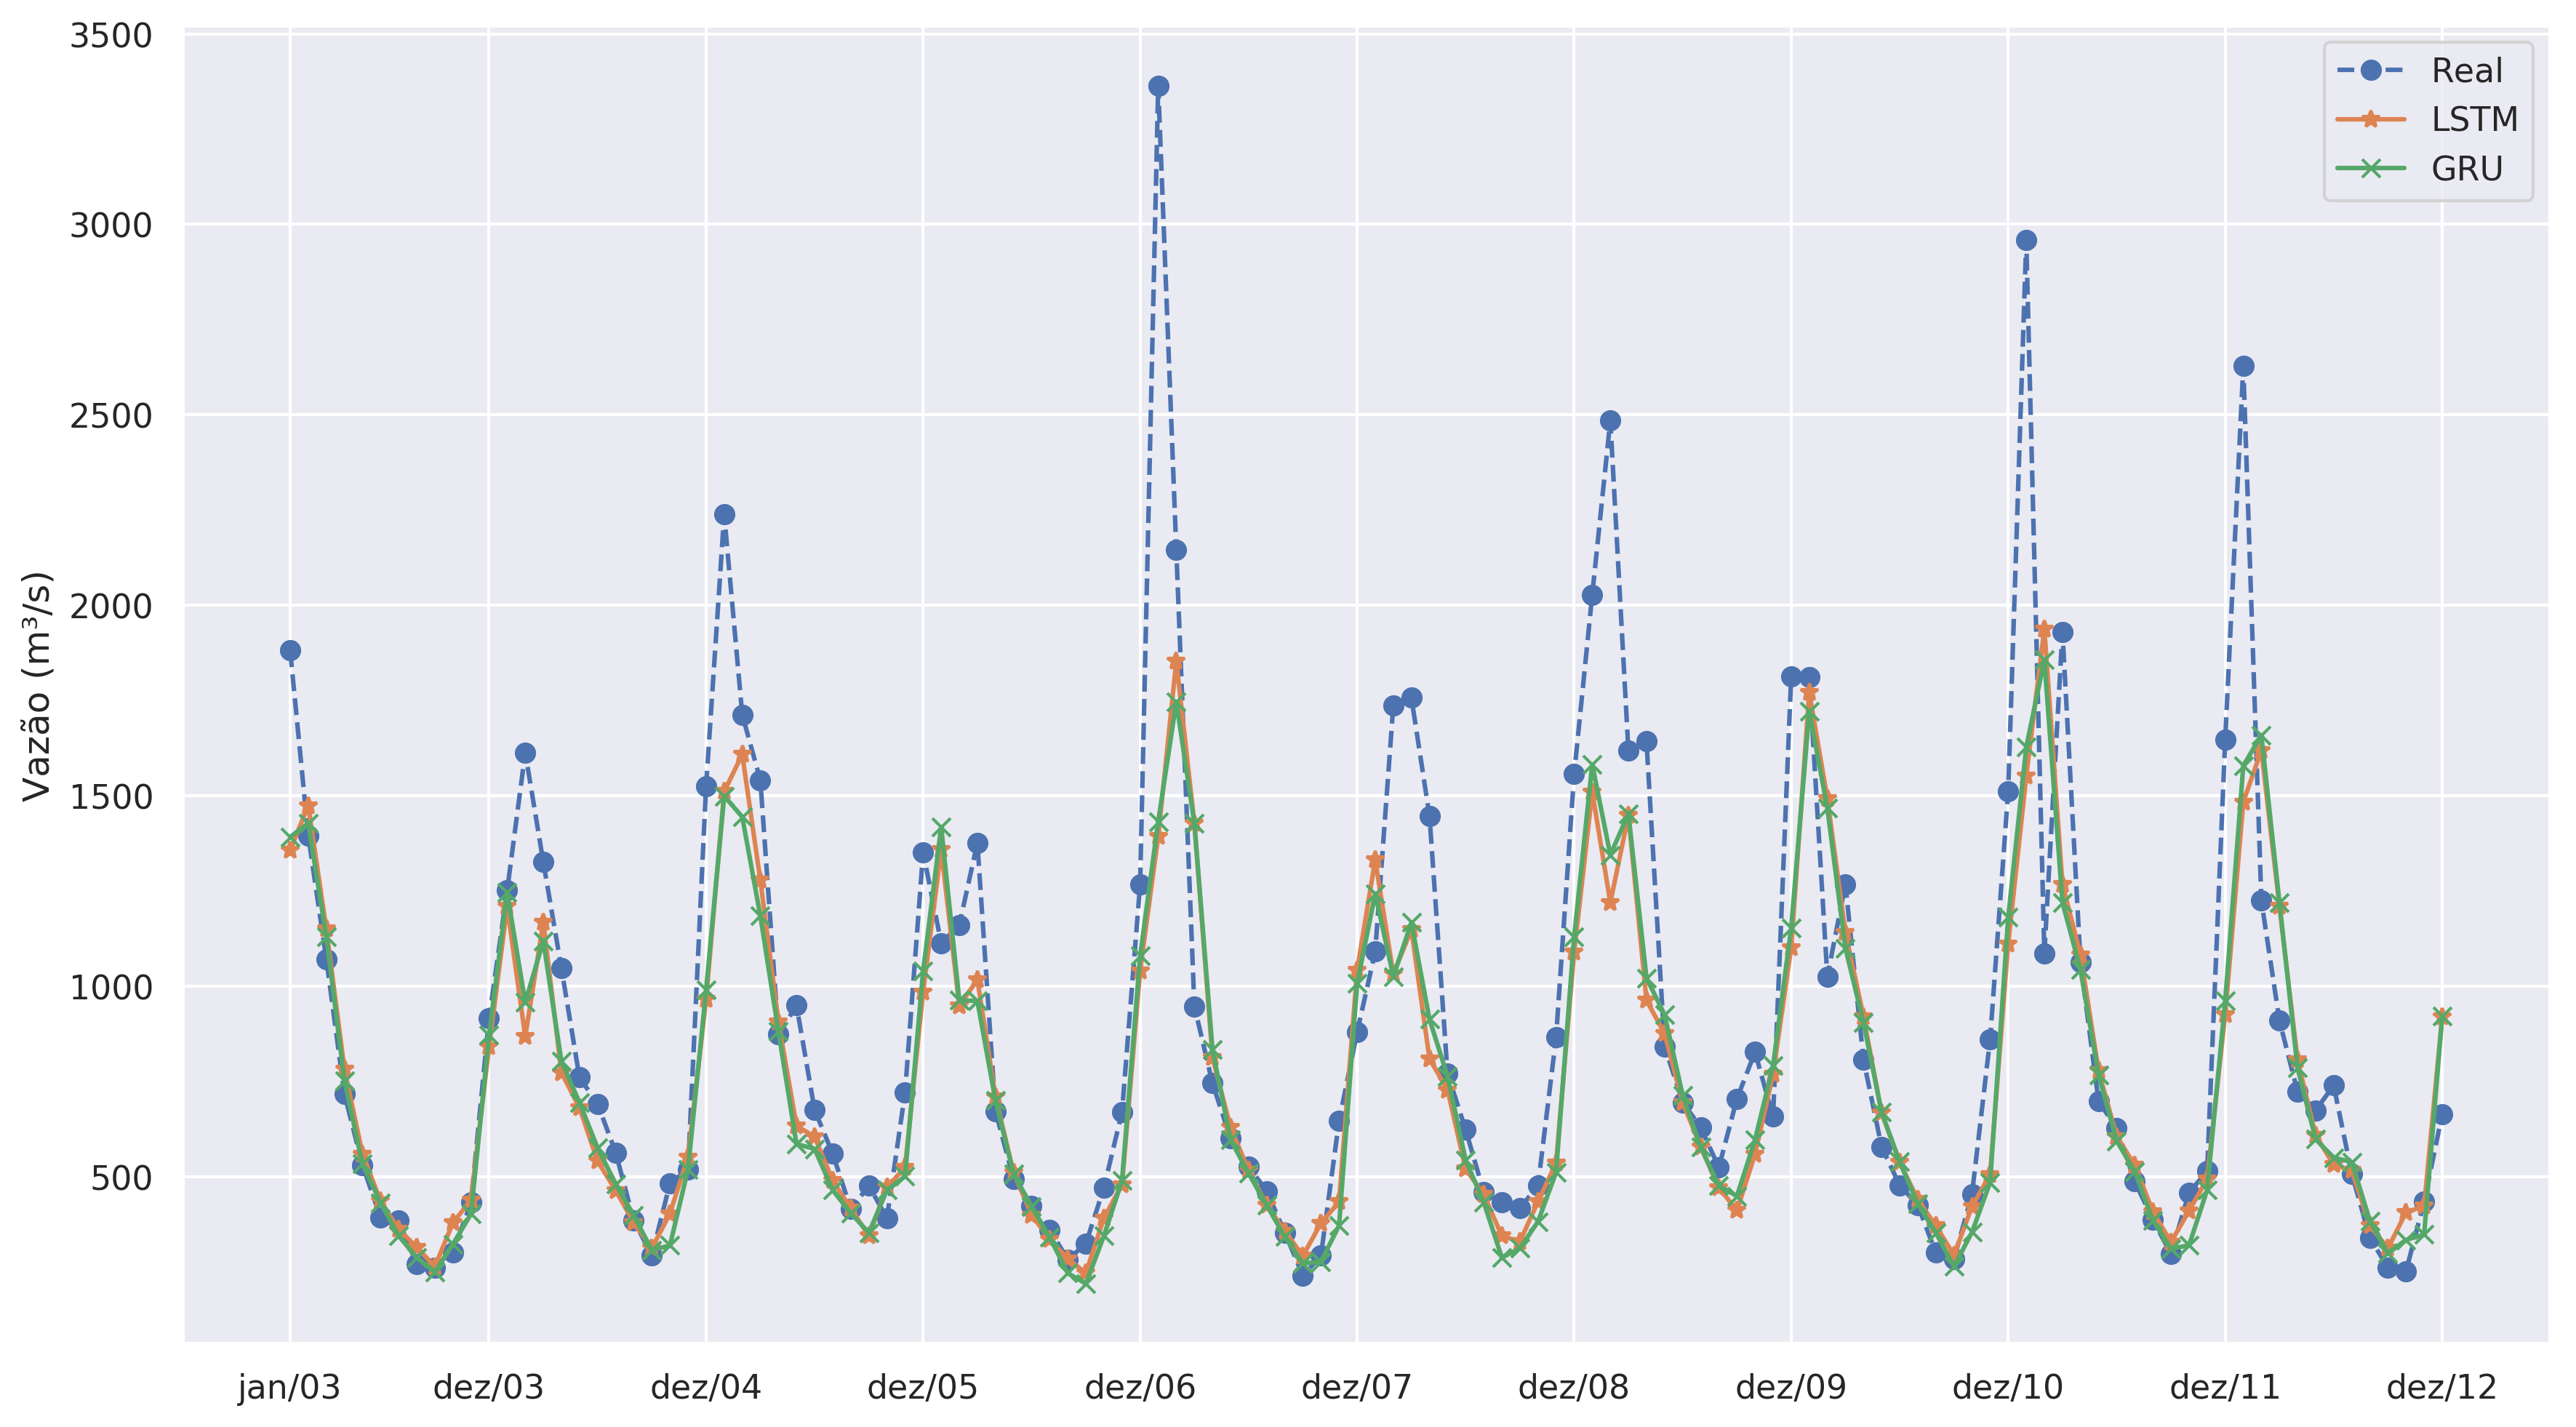

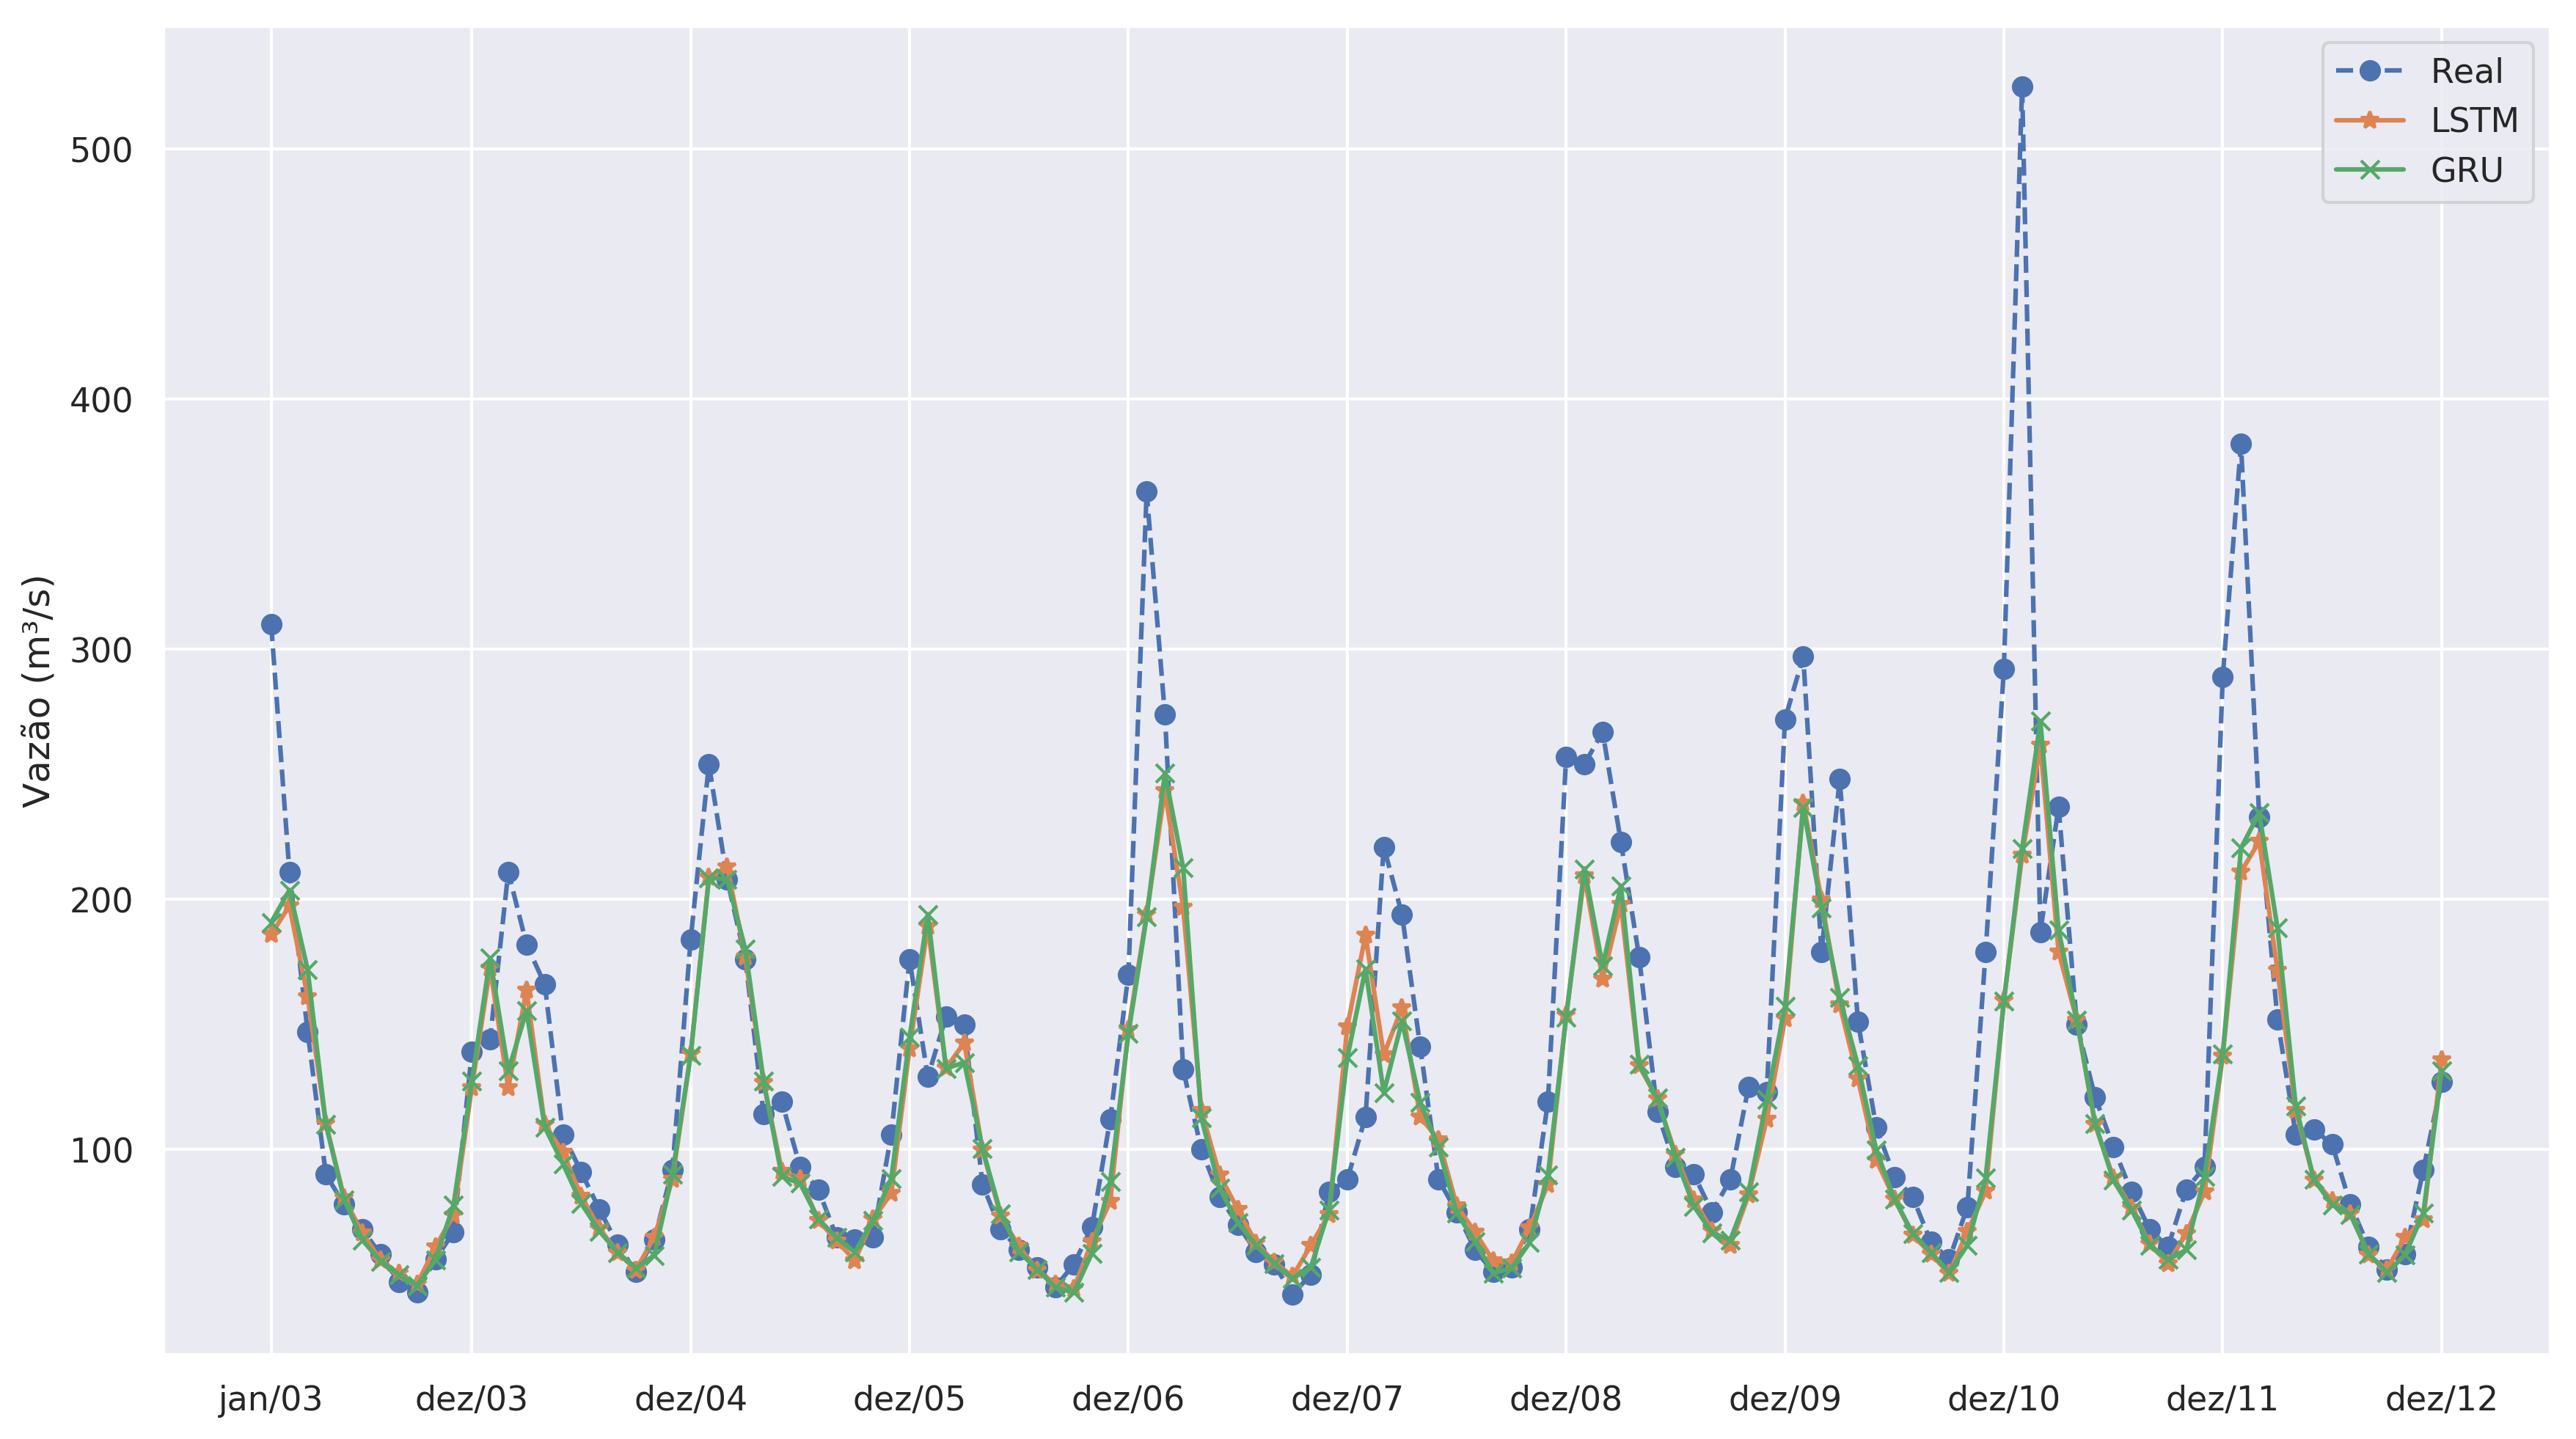

In [19]:
predito_lstm = lstm.predict([x_teste_reco, m_teste_reco])
predito_gru = gru.predict([x_teste_reco, m_teste_reco])

for i in range(2):
    plt.figure(dpi=300)
    plt.plot(y_teste_reco[:, i]*fatores_normalizacao[i], '--o')
    plt.plot(predito_lstm[:, i]*fatores_normalizacao[i], '-*')
    plt.plot(predito_gru[:, i]*fatores_normalizacao[i], '-x')
    plt.legend(['Real', 'LSTM', 'GRU'], loc='upper right')
    plt.xticks([0]+[(k+1)*12-1 for k in range(10)], ['jan/03']+['dez/%02d'%(k+3) for k in range(10)])
    plt.ylabel('Vazão (m³/s)')